# **Data Preparation For Classification**

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from scipy.stats import entropy

In [3]:
cyclists_df = pd.read_csv('../dataset/cleaned_cyclists.csv')
races_df = pd.read_csv('../dataset/cleaned_races.csv')

In [4]:
races_df.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'start_date', 'duration'],
      dtype='object')

## Data Cleaning for Classification

Given that we leave pending the drop of stages with climb total or profile null, we firstly perform that in order to simplify the classification task

In [5]:
initial_rows = len(races_df)
races_df.dropna(subset=['climb_total', 'profile'], inplace=True)
rows_dropped = initial_rows - len(races_df)
print(f"Number of rows dropped: {rows_dropped}")


Number of rows dropped: 180556


Add cyclists number to the dataframe, is a support column used to compute relative positions

In [6]:
# Count the number of occurrences of each _url
url_counts = races_df['_url'].value_counts().reset_index()
url_counts.columns = ['_url', 'cyclist_number']

# Merge the counts back to the original dataframe
races_df = races_df.merge(url_counts, on='_url', how='left')

Given that the task is binary on position classifing in top_20 and rest of the cyclists, on professor advice, we decided to drop stages with less then

In [7]:
initial_rows = len(races_df)
races_df = races_df[races_df['cyclist_number'] >= 25]
rows_dropped = initial_rows - len(races_df)
print(f"Number of rows dropped: {rows_dropped}") 

Number of rows dropped: 56


In [8]:
races_df["cyclist_number"].describe()

count    409004.000000
mean        161.461717
std          24.616266
min          33.000000
25%         147.000000
50%         165.000000
75%         179.000000
max         210.000000
Name: cyclist_number, dtype: float64

## Feature Engineering

### ```top_20```  column

This columns represents the classification label, is 1 if position is smaller or equal to 20 and is 

In [9]:
races_df['top_20'] = races_df['position'].apply(lambda x: 1 if x <= 20 else 0)

In [10]:
races_df['top_20'].value_counts()
# Print value counts
value_counts = races_df['top_20'].value_counts()
print("Value Counts:")
print(value_counts)

# Print percentages
percentages = races_df['top_20'].value_counts(normalize=True) * 100
print("\nPercentages:")
print(percentages)


Value Counts:
top_20
0    354195
1     54809
Name: count, dtype: int64

Percentages:
top_20
0    86.599398
1    13.400602
Name: proportion, dtype: float64


### ```cyclist_level```  column

This feature inserts at each races row the level of the relevant rider up to and including that day. The level is calculated in the following way

In [11]:
# sort races by cyclist name and start date
races_df = races_df.sort_values(by=["cyclist", "start_date"])

# compute weighted points for each stage
races_df["weighted_points"] = races_df["points"] * (1-(1+races_df["position"]) / races_df["cyclist_number"])

# compute career level
races_df["cyclist_level"] = (
    races_df.groupby("cyclist")["weighted_points"]
    .cumsum()
    .add(0)
)

# previous computations are cumulative and fill first value for each different cyclist with values from 
# previous one, so shift all and insert a 0 at beginning of each cyclist
races_df["cyclist_level"] = races_df.groupby("cyclist")["cyclist_level"].shift(fill_value=0)

races_df.drop(columns="weighted_points", inplace=True)

races_df[["_url","cyclist","start_date","position","cyclist_number","points","cyclist_level"]].head()


,_url,cyclist,start_date,position,cyclist_number,points,cyclist_level
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,28,110,100.0,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,88,109,100.0,73.636364
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,57,109,100.0,91.984987
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,47,108,100.0,138.773978
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,79,106,100.0,194.329534


### ```cyclist_experience```  column

This feature inserts at each races row the number of stages on which a cyclist participate to up that stage

In [12]:
# Compute cyclist experience, resetting for each cyclist
races_df["cyclist_experience"] = (
    races_df.groupby("cyclist").cumcount()  # count rows for each cyclist group
    .add(0)                                 # start from 0
)

races_df[["_url","cyclist","start_date","cyclist_experience", "cyclist_level"]].head(8)


,_url,cyclist,start_date,cyclist_experience,cyclist_level
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,0,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,1,73.636364
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,2,91.984987
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,3,138.773978
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,4,194.329534
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,5,218.857836
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,6,240.555949
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,7,260.367270


### ```avg_relative_position```  column

This feature inserts at each races row the average relative position reached by the cyclists untill that stage

In [13]:
# compute relative position for each stage
races_df["relative_position"] = (races_df["position"] + 1) / races_df["cyclist_number"]

# compute relative position summation
races_df["relative_position_sum"] = (
    races_df.groupby("cyclist")["relative_position"]
    .cumsum()
    .shift(fill_value=0)  # shift to exclude the current stage
)

races_df["avg_relative_position"] = races_df["relative_position_sum"] / races_df["cyclist_experience"]

races_df["avg_relative_position"] = races_df["avg_relative_position"].fillna(0)
races_df["avg_relative_position"] = races_df["avg_relative_position"].replace([float('inf'), -float('inf')], 0)

races_df[["_url","cyclist","start_date","relative_position_sum","relative_position","avg_relative_position"]].head(8)

,_url,cyclist,start_date,relative_position_sum,relative_position,avg_relative_position
41968,tour-de-france/1978/prologue,aad-van-den-hoek,1978-06-29,0.000000,0.263636,0.000000
117821,tour-de-france/1978/stage-1a,aad-van-den-hoek,1978-06-30,0.263636,0.816514,0.263636
174397,tour-de-france/1978/stage-1b,aad-van-den-hoek,1978-06-30,1.080150,0.532110,0.540075
331237,tour-de-france/1978/stage-2,aad-van-den-hoek,1978-07-01,1.612260,0.444444,0.537420
21609,tour-de-france/1978/stage-3,aad-van-den-hoek,1978-07-02,2.056705,0.754717,0.514176
274179,tour-de-france/1978/stage-5,aad-van-den-hoek,1978-07-04,2.811422,0.783019,0.562284
84,tour-de-france/1978/stage-6,aad-van-den-hoek,1978-07-05,3.594441,0.801887,0.599073
168634,tour-de-france/1978/stage-7,aad-van-den-hoek,1978-07-06,4.396327,0.613208,0.628047


In [14]:
races_df.drop(columns="relative_position_sum", inplace=True)

In [15]:
races_df.columns

Index(['_url', 'name', 'points', 'length', 'climb_total', 'profile',
       'startlist_quality', 'position', 'cyclist', 'cyclist_age', 'is_tarmac',
       'cyclist_team', 'start_date', 'duration', 'cyclist_number', 'top_20',
       'cyclist_level', 'cyclist_experience', 'relative_position',
       'avg_relative_position'],
      dtype='object')

### ```position_entropy```  column modify

In [16]:
# Funzione per calcolare l'entropia cumulativa
def calculate_entropy(positions):
    if len(positions) <= 1:
        return 0  # Entropia nulla se non ci sono abbastanza dati
    value_counts = positions.value_counts(normalize=True)  # Probabilità delle posizioni
    return entropy(value_counts, base=2)  # Calcolo dell'entropia con base 2

# Calcolo cumulativo dell'entropia
races_df["position_entropy"] = (
    races_df.groupby("cyclist")["position"]
    .expanding()  # Espansione per includere tutte le righe precedenti
    .apply(lambda x: calculate_entropy(x[:-1]), raw=False)  # Escludiamo la riga corrente
    .reset_index(level=0, drop=True)  # Manteniamo il formato originale
)

In [26]:
races_df[["_url", "cyclist", "start_date", "position", "position_entropy"]].head(60)
print(races_df[["cyclist", "start_date", "position", "position_entropy"]].iloc[40:80])

                 cyclist  start_date  position  position_entropy
194064  aad-van-den-hoek  1981-07-14       120          5.021928
257389  aad-van-den-hoek  1981-07-15       121          5.064869
71046   aad-van-den-hoek  1981-07-16       106          5.106603
270746  aad-van-den-hoek  1981-07-17       120          5.147195
207373  aad-van-den-hoek  1981-07-18        70          5.141250
126146  aad-van-den-hoek  1981-07-19        96          5.180742
215673        aaron-gate  2017-04-23       135          0.000000
378262        aaron-gate  2017-06-10        57          0.000000
350127        aaron-gate  2017-06-11        13          1.000000
304488        aaron-gate  2017-06-12        47          1.584963
401515        aaron-gate  2017-06-13        79          2.000000
311741        aaron-gate  2017-06-14         8          2.321928
344285        aaron-gate  2017-06-15        93          2.584963
341383        aaron-gate  2017-06-16        78          2.807355
241755        aaron-gate 

In [27]:
# Group by cyclist and get the maximum cyclist level for each cyclist
max_cyclist_levels = races_df.groupby('cyclist')['cyclist_level'].max()

# Sort the cyclists by their maximum cyclist level in descending order and get the top 3
top_3_cyclists = max_cyclist_levels.sort_values(ascending=False).head(3).index.tolist()

print(top_3_cyclists)

['alejandro-valverde', 'vincenzo-nibali', 'bauke-mollema']


In [28]:
for cyclist in top_3_cyclists:
    max_level = max_cyclist_levels[cyclist]
    print(f"Max cyclist level for {cyclist}: {max_level}")

Max cyclist level for alejandro-valverde: 59565.19123883357
Max cyclist level for vincenzo-nibali: 52177.729910035916
Max cyclist level for bauke-mollema: 46165.158325405624


In [29]:
vinicius_rangel_costa_df = races_df[races_df['cyclist'] == 'vinicius-rangel-costa']
vinicius_rangel_costa_df[["_url","points","position","cyclist_number","cyclist_level","avg_relative_position","position_entropy"]].head(8)

,_url,points,position,cyclist_number,cyclist_level,avg_relative_position,position_entropy
10193,amstel-gold-race/2022/result,225.0,125,126,0.0,0.0,0.0
69783,dwars-door-vlaanderen/2023/result,225.0,128,142,0.0,1.0,0.0


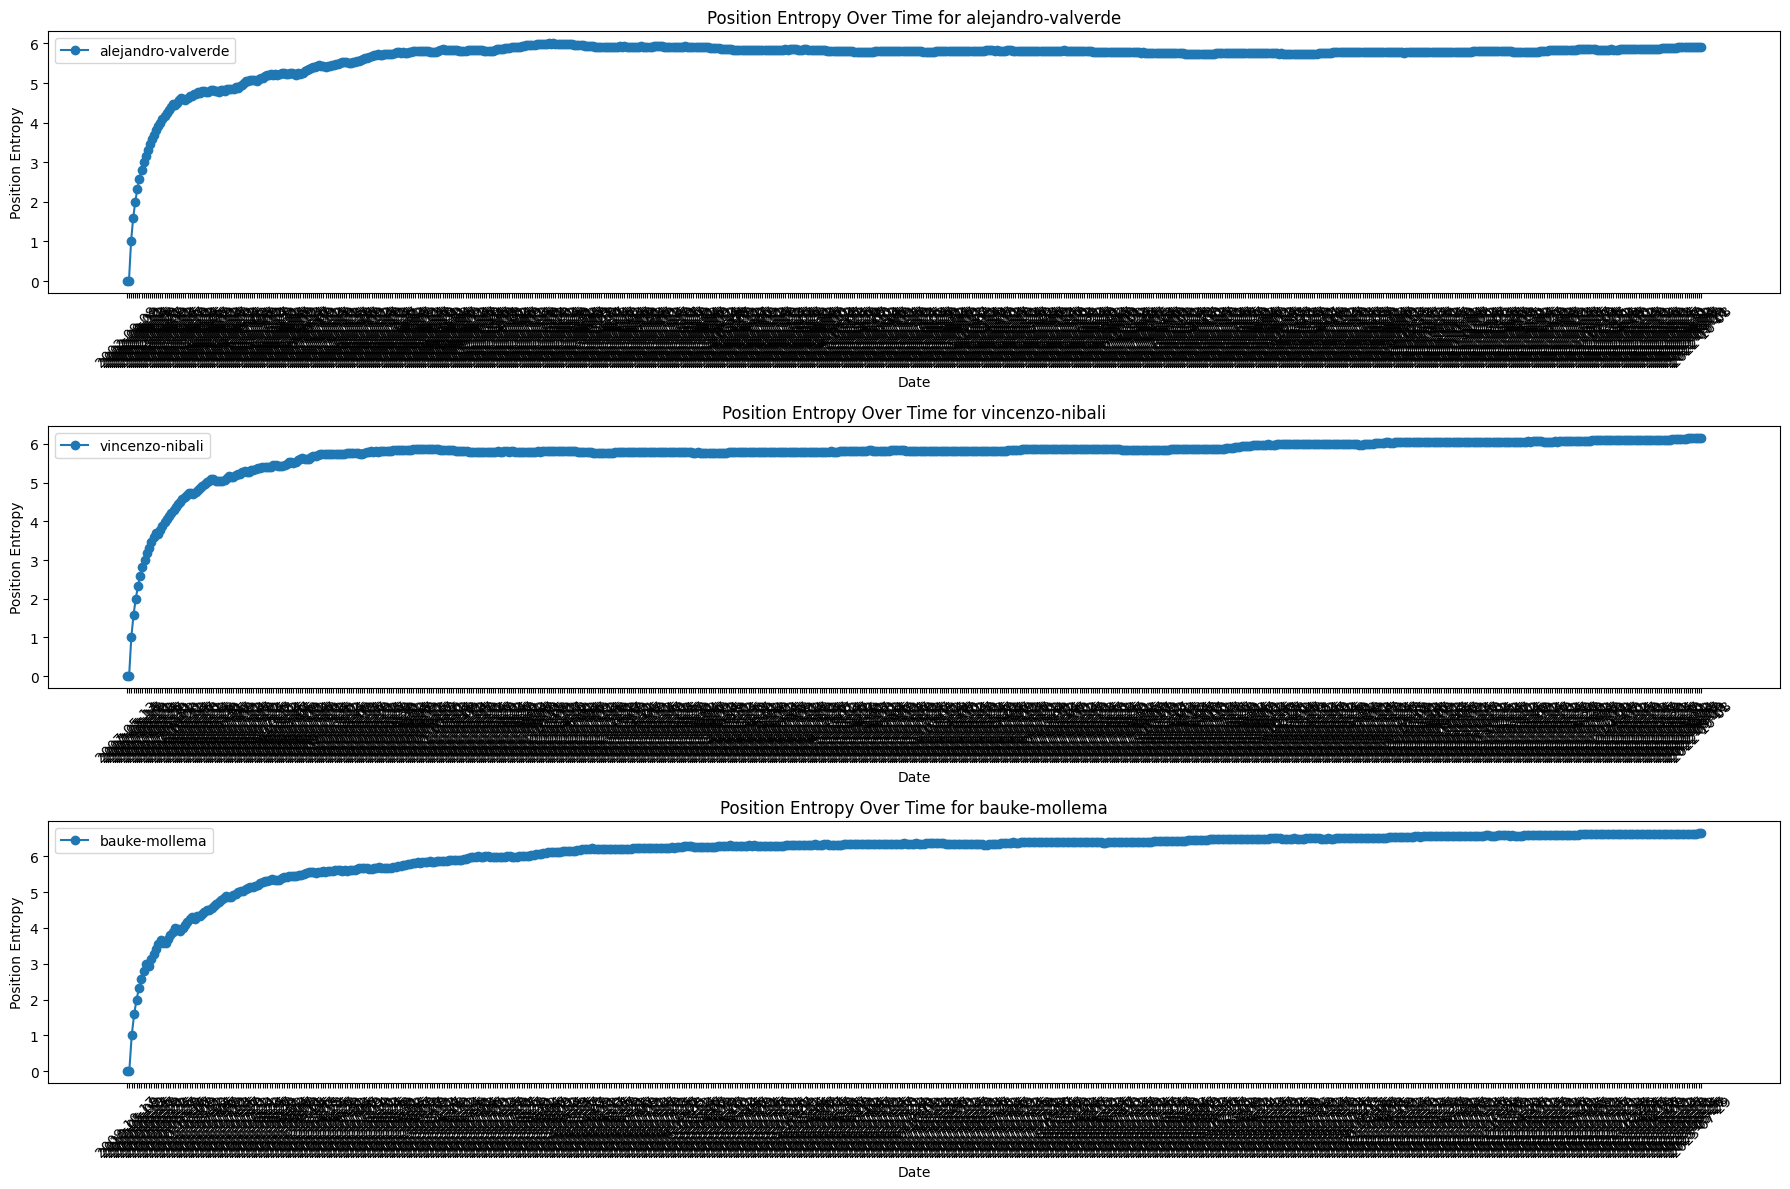

In [30]:
import matplotlib.pyplot as plt

# Filter the dataframe for the famous cyclists
famous_cyclists_df = races_df[races_df['cyclist'].isin(top_3_cyclists)]

# Plot the entropy over time for each famous cyclist in separate plots
plt.figure(figsize=(18, 12))

for i, cyclist in enumerate(top_3_cyclists, 1):
    subset = famous_cyclists_df[famous_cyclists_df['cyclist'] == cyclist]
    plt.subplot(3, 1, i)
    plt.plot(subset['start_date'], subset['position_entropy'], marker='o', label=cyclist)
    plt.xlabel('Date')
    plt.ylabel('Position Entropy')
    plt.title(f'Position Entropy Over Time for {cyclist}')
    plt.legend()
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### ```is_tarmac```  column modify

In [31]:
# Convert boolean columns to integers
races_df['is_tarmac'] = races_df['is_tarmac'].astype(int)

races_df["is_tarmac"].value_counts()

is_tarmac
1    390859
0     18145
Name: count, dtype: int64